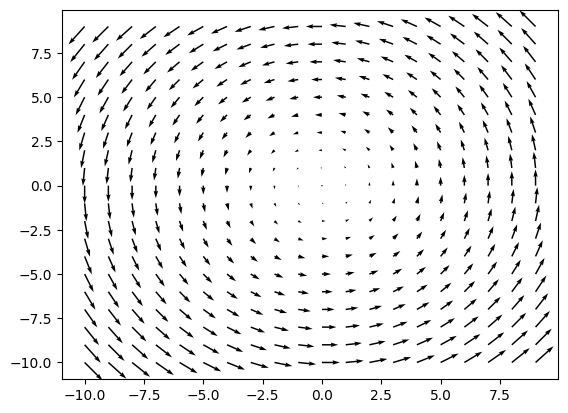

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.meshgrid(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
u = -y
v = x

fig, ax = plt.subplots()
ax.quiver(x, y, u, v)

plt.show()

In [2]:
import nibabel as nib
import nibabel.processing as nip
import nibabel.orientations as nio
import numpy as np
import os
import glob
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu


In [3]:
def resample_nib(img, voxel_spacing=(1, 1, 1), order=3):
    """Resamples the nifti from its original spacing to another specified spacing
    
    Parameters:
    ----------
    img: nibabel image
    voxel_spacing: a tuple of 3 integers specifying the desired new spacing
    order: the order of interpolation
    
    Returns:
    ----------
    new_img: The resampled nibabel image 
    
    """
    # resample to new voxel spacing based on the current x-y-z-orientation
    aff = img.affine
    shp = img.shape
    zms = img.header.get_zooms()
    # Calculate new shape
    new_shp = tuple(np.rint([
        shp[0] * zms[0] / voxel_spacing[0],
        shp[1] * zms[1] / voxel_spacing[1],
        shp[2] * zms[2] / voxel_spacing[2]
        ]).astype(int))
    new_aff = nib.affines.rescale_affine(aff, shp, voxel_spacing, new_shp)
    new_img = nip.resample_from_to(img, (new_shp, new_aff), order=order)
    print("[*] Image resampled to voxel size:", voxel_spacing)
    return new_img

In [4]:
in_path = "/home/GRAMES.POLYMTL.CA/p118945/data_nvme_p118945/multi_contrast_nir/spine_generic/sub-hamburg02/01"

In [5]:
file_list = glob.glob(os.path.join(in_path,'*.nii.gz'))

In [6]:
file_list

['/home/GRAMES.POLYMTL.CA/p118945/data_nvme_p118945/multi_contrast_nir/spine_generic/sub-hamburg02/01/sub-hamburg02_T2w_mask_LR.nii.gz',
 '/home/GRAMES.POLYMTL.CA/p118945/data_nvme_p118945/multi_contrast_nir/spine_generic/sub-hamburg02/01/sub-hamburg02_bodymask.nii.gz',
 '/home/GRAMES.POLYMTL.CA/p118945/data_nvme_p118945/multi_contrast_nir/spine_generic/sub-hamburg02/01/sub-hamburg02_T2w.nii.gz',
 '/home/GRAMES.POLYMTL.CA/p118945/data_nvme_p118945/multi_contrast_nir/spine_generic/sub-hamburg02/01/sub-hamburg02_T1w_LR.nii.gz',
 '/home/GRAMES.POLYMTL.CA/p118945/data_nvme_p118945/multi_contrast_nir/spine_generic/sub-hamburg02/01/sub-hamburg02_T2w_LR.nii.gz',
 '/home/GRAMES.POLYMTL.CA/p118945/data_nvme_p118945/multi_contrast_nir/spine_generic/sub-hamburg02/01/sub-hamburg02_T1w_mask_LR.nii.gz',
 '/home/GRAMES.POLYMTL.CA/p118945/data_nvme_p118945/multi_contrast_nir/spine_generic/sub-hamburg02/01/sub-hamburg02_T1w.nii.gz']

In [30]:
def create_mask2(img):
    img_data = img.get_fdata()
    img_affine = img.affine
    
    # Threshold the data using Otsu's algorithm
    #thresh = threshold_otsu(img_data)
    thresh = 10
    img_mask = np.where(img_data > thresh, 1, 0).astype(np.uint8)
    print(thresh)
    
    # Identify the external part of the body using binary erosion
    from scipy.ndimage.morphology import binary_erosion
    ext_mask = binary_erosion(img_mask, iterations=3)
    #ext_mask = img_mask
    
    mask_data = np.zeros_like(img_mask)
    mask_data[ext_mask == 1] = 1
    img_mask_img = nib.Nifti1Image(mask_data, img_affine)
    return img_mask_img

def create_mask(img):
    img_data = img.get_fdata()
    img_affine = img.affine
    mask_data = np.zeros_like(img_data)
    mask_data[mask_data == 0] = 1
    return nib.Nifti1Image(mask_data.astype(np.uint8), img_affine)
    

In [7]:
for root, dirs, files in os.walk(in_path):
    for name in files:
        if "T2w.nii.gz" in name:
            t2_name = os.path.join(root, name)
            t1_name = t2_name.replace("T2w","T1w")
            # dir_name = flare_name.replace("flair","dir")
            mask_name = t2_name.replace("T2w","bodymask")
            
            img_t2 = nib.load(t2_name)
            img_t1 = nib.load(t1_name)
            # img_dir = nib.load(dir_name)
            mask = create_mask(img_t2)
            nib.save(mask, mask_name)

In [8]:
sizes = []
shape_ = np.array([160, 224, 160])
for root, dirs, files in os.walk(in_path):
    for name in files:
        if "T2w.nii.gz" in name:
            t2_name = os.path.join(root, name)
            t1_name = t2_name.replace("T2w","T1w")
            # dir_name = flare_name.replace("flair","dir")
            mask_name = t2_name.replace("T2w","bodymask")
            
            img_t2 = nib.load(t2_name)
            img_t1 = nib.load(t1_name)
            # img_dir = nib.load(dir_name)
            mask = create_mask(img_t2)
            nib.save(mask, mask_name)
            
            mask_data = mask.get_fdata()
            '''
            props = regionprops(mask_data)
            
            box = np.array(props[0].bbox)
            span = box[3:]-box[:3]
            padd = shape_-span
            padd_l = np.fmin(padd//2, box[:3])
            padd_r = padd-padd_l
            
            box[:3] -= padd_l
            box[3:] += padd_r
            
            # print(box)
            
            img_flair = nib.nifti1.Nifti1Image(img_flair.get_data()[box[0]:box[3],box[1]:box[4],box[2]:box[5]], affine=img_flair.get_affine())
            img_t1 = nib.nifti1.Nifti1Image(img_t1.get_data()[box[0]:box[3],box[1]:box[4],box[2]:box[5]], affine=img_t1.get_affine())
            # img_dir = nib.nifti1.Nifti1Image(img_dir.get_data()[box[0]:box[3],box[1]:box[4],box[2]:box[5]], affine=img_t1.get_affine())
            mask = nib.nifti1.Nifti1Image(mask.get_data()[box[0]:box[3],box[1]:box[4],box[2]:box[5]], affine=mask.get_affine())
            
            if not os.path.exists(os.path.split(flare_name.replace("msseg_segmentation_challenge","NeRF_MS16_data"))[0]):
                os.makedirs(os.path.split(flare_name.replace("msseg_segmentation_challenge","NeRF_MS16_data"))[0])
            
            
            nib.save(img_flair, flare_name.replace("msseg_segmentation_challenge","NeRF_MS16_data"))  
            nib.save(img_t1, t1_name.replace("msseg_segmentation_challenge","NeRF_MS16_data"))
            # nib.save(img_dir, dir_name.replace("msseg_segmentation_challenge","NeRF_MS16_data")) 
            nib.save(mask, mask_name.replace("msseg_segmentation_challenge","NeRF_MS16_data")) 
            '''
            
            img_t2 = resample_nib(img_t2, voxel_spacing=(4.0, 0.8, 0.8), order=1)
            img_t1 = resample_nib(img_t1, voxel_spacing=(0.8, 0.8, 4.0), order=1)
            # img_dir = resample_nib(img_dir, voxel_spacing=(1.0, 1.0, 4.0), order=3)
            
            mask_t2 = resample_nib(mask, voxel_spacing=(4.0, 0.8, 0.8), order=0)
            mask_t1 = resample_nib(mask, voxel_spacing=(0.8, 0.8, 4.0), order=0)
            # mask_dir = resample_nib(mask, voxel_spacing=(1.0, 1.0, 4.0), order=0)
                
            nib.save(img_t2, t2_name.replace("T2w","T2w_LR"))  
            nib.save(img_t1, t1_name.replace("T1w","T1w_LR"))  
            # nib.save(img_dir, dir_name.replace("msseg_segmentation_challenge","NeRF_MS16_data").replace("dir","dir_LR"))
            
            nib.save(mask_t2, t2_name.replace("T2w","T2w_mask_LR"))  
            nib.save(mask_t1, t1_name.replace("T1w","T1w_mask_LR"))
            # nib.save(mask_dir, dir_name.replace("msseg_segmentation_challenge","NeRF_MS16_data").replace("dir","dir_mask_LR"))

            # print(os.path.join(root, name))


[*] Image resampled to voxel size: (4.0, 0.8, 0.8)
[*] Image resampled to voxel size: (0.8, 0.8, 4.0)
[*] Image resampled to voxel size: (4.0, 0.8, 0.8)
[*] Image resampled to voxel size: (0.8, 0.8, 4.0)


In [7]:
im = nib.load("/home/GRAMES.POLYMTL.CA/p118945/data_nvme_p118945/multi_contrast_nir/spine_generic/sub-hamburg02/01/sub-hamburg02_T2w_LR.nii.gz")

In [8]:
im.header.get_zooms()

(4.0, 0.8, 0.8)